# 2 Sample Tests Power over Increasing Dimension

In [1]:
import sys, os

from joblib import Parallel, delayed
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns

from hyppo.independence import MGC, Dcorr, Hsic, HHG, CCA, RV
from power_2samp import power_ksamp
sys.path.append(os.path.realpath('..'))

In [2]:
from sklearn.ensemble import RandomForestRegressor, RandomForestClassifier
from sklearn.metrics import pairwise_distances
from scipy.stats.distributions import chi2

from hyppo.independence.base import IndependenceTest
from hyppo.independence.dcorr import _dcorr
from hyppo.independence._utils import sim_matrix
from hyppo.ksample import k_sample_transform


FOREST_TYPES = {
    "classifier" : RandomForestClassifier,
    "regressor" : RandomForestRegressor
}


class KMERF(IndependenceTest):
    r"""
    Class for calculating the random forest based Dcorr test statistic and p-value.
    """

    def __init__(self, forest="classifier", ntrees=500, **kwargs):
        if forest in FOREST_TYPES.keys():
            self.clf = FOREST_TYPES[forest](n_estimators=ntrees, **kwargs)
        else:
            raise ValueError("forest must be one of the following ")
        IndependenceTest.__init__(self)

    def statistic(self, x, y):
        r"""
        Helper function that calculates the random forest based Dcorr test statistic.
        """
        rf_y = y
        if y.shape[1] == 1:
            rf_y = y.ravel()
        self.clf.fit(x, rf_y)
        self.first_time = False
        distx = np.sqrt(1 - sim_matrix(self.clf, x))
        if x.shape[1] == y.shape[1]:
            disty = np.sqrt(1 - sim_matrix(self.clf, y))
        else:
            disty = pairwise_distances(
                y, metric="euclidean"
            )
        stat = _dcorr(distx, disty, bias=False, is_fast=False)

        return stat
    
    def test(self, x, y):
        n = x.shape[0]
        u, v = k_sample_transform([x, y], test_type="rf")
        stat = self.statistic(u, v)
        us = k_sample_transform([u, u], test_type="rf")
        vs = k_sample_transform([v, v], test_type="rf")
        statx = self.statistic(*us)
        staty = self.statistic(*vs)
        pvalue = chi2.sf(stat / np.sqrt(statx * staty) * n + 1, 1)
        return stat, pvalue

In [3]:
sns.set(color_codes=True, style='white', context='talk', font_scale=1.5)
PALETTE = sns.color_palette("Set1")
sns.set_palette(PALETTE[1:5] + PALETTE[6:], n_colors=9)

MAX_DIMENSION = 10
STEP_SIZE = 1
DIMENSIONS = range(3, MAX_DIMENSION + STEP_SIZE, STEP_SIZE)
POWER_REPS = 5
REPS = 10000

SIMULATIONS = {
    "linear": "Linear",
    "exponential": "Exponential",
    "cubic": "Cubic",
    "joint_normal": "Joint Normal",
    "step": "Step",
    "quadratic": "Quadratic",
    "w_shaped": "W-Shaped",
    "spiral": "Spiral",
    "uncorrelated_bernoulli": "Bernoulli",
    "logarithmic": "Logarithmic",
    "fourth_root": "Fourth Root",
    "sin_four_pi": "Sine 4\u03C0",
    "sin_sixteen_pi": "Sine 16\u03C0",
    "square": "Square",
    "two_parabolas": "Two Parabolas",
    "circle": "Circle",
    "ellipse": "Ellipse",
    "diamond": "Diamond",
    "multiplicative_noise": "Multiplicative",
    "multimodal_independence": "Independence"
}

TESTS = [
    KMERF,
    MGC,
    Dcorr,
    Hsic,
    HHG,
    CCA,
    RV,
]

In [4]:
RENAME_TESTS = {
    "Dcorr": "Energy",
    "Hsic": "MMD"
}

def estimate_power(sim, test):
    est_power = np.array([power_ksamp(test, sim, n=100, p=dim, noise=False, reps=REPS)
                          for dim in DIMENSIONS])
    if test.__name__ in ["Dcorr", "Hsic"]:
        np.savetxt('../kmerf/2samp_vs_dimension/{}_{}.csv'.format(sim, RENAME_TESTS[test.__name__]),
               est_power, delimiter=',')
    else:
        np.savetxt('../kmerf/2samp_vs_dimension/{}_{}.csv'.format(sim, test.__name__),
                   est_power, delimiter=',')
    
    return est_power

In [5]:
# Uncomment the code below to reproduce power results.
# Note, this takes a very long time to run. Highly recommend using a virtual machine to reproduce.
# outputs = Parallel(n_jobs=-1, verbose=100)(
#     [delayed(estimate_power)(sim, test) for sim in SIMULATIONS.keys() for test in TESTS]
# )

In [14]:
def plot_power():
    fig, ax = plt.subplots(nrows=4, ncols=5, figsize=(25,20))
    
    plt.suptitle("Multivariate Two-Sample Testing (Increasing Dimension)", y=0.93, va='baseline')
    
    for i, row in enumerate(ax):
        for j, col in enumerate(row):
            count = 5*i + j
            sim = list(SIMULATIONS.keys())[count]
            
            for test in TESTS[::-1]:
                test_name = test.__name__
                if test_name == "Dcorr":
                    test_name = "Energy"
                elif test_name == "Hsic":
                    test_name = "MMD"
                power = np.genfromtxt('../kmerf/2samp_vs_dimension/{}_{}.csv'.format(sim, test_name), delimiter=',')

                if test_name == "KMERF":
                    col.plot(DIMENSIONS, power, color="#e41a1c", label=test_name, lw=4)
                else:
                    col.plot(DIMENSIONS, power, label=test_name, lw=2)
                col.set_xticks([DIMENSIONS[0], DIMENSIONS[-1]])
                col.set_ylim(-0.05, 1.05)
                col.set_yticks([])
                if j == 0:
                    col.set_yticks([0, 1])
                col.set_title(SIMULATIONS[sim])
    
    fig.text(0.5, 0.07, 'Dimension', ha='center')
    fig.text(0.07, 0.5, 'Statistical Power', va='center', rotation='vertical')
    leg = plt.legend(bbox_to_anchor=(0.5, 0.07), bbox_transform=plt.gcf().transFigure,
                     ncol=len(TESTS), loc='upper center', reverse=True)
    leg.get_frame().set_linewidth(0.0)
    for legobj in leg.legend_handles:
        legobj.set_linewidth(5.0)
    plt.subplots_adjust(hspace=.50)
    plt.savefig('../kmerf/figs/2samp_power_dimension.pdf', transparent=True, bbox_inches='tight')

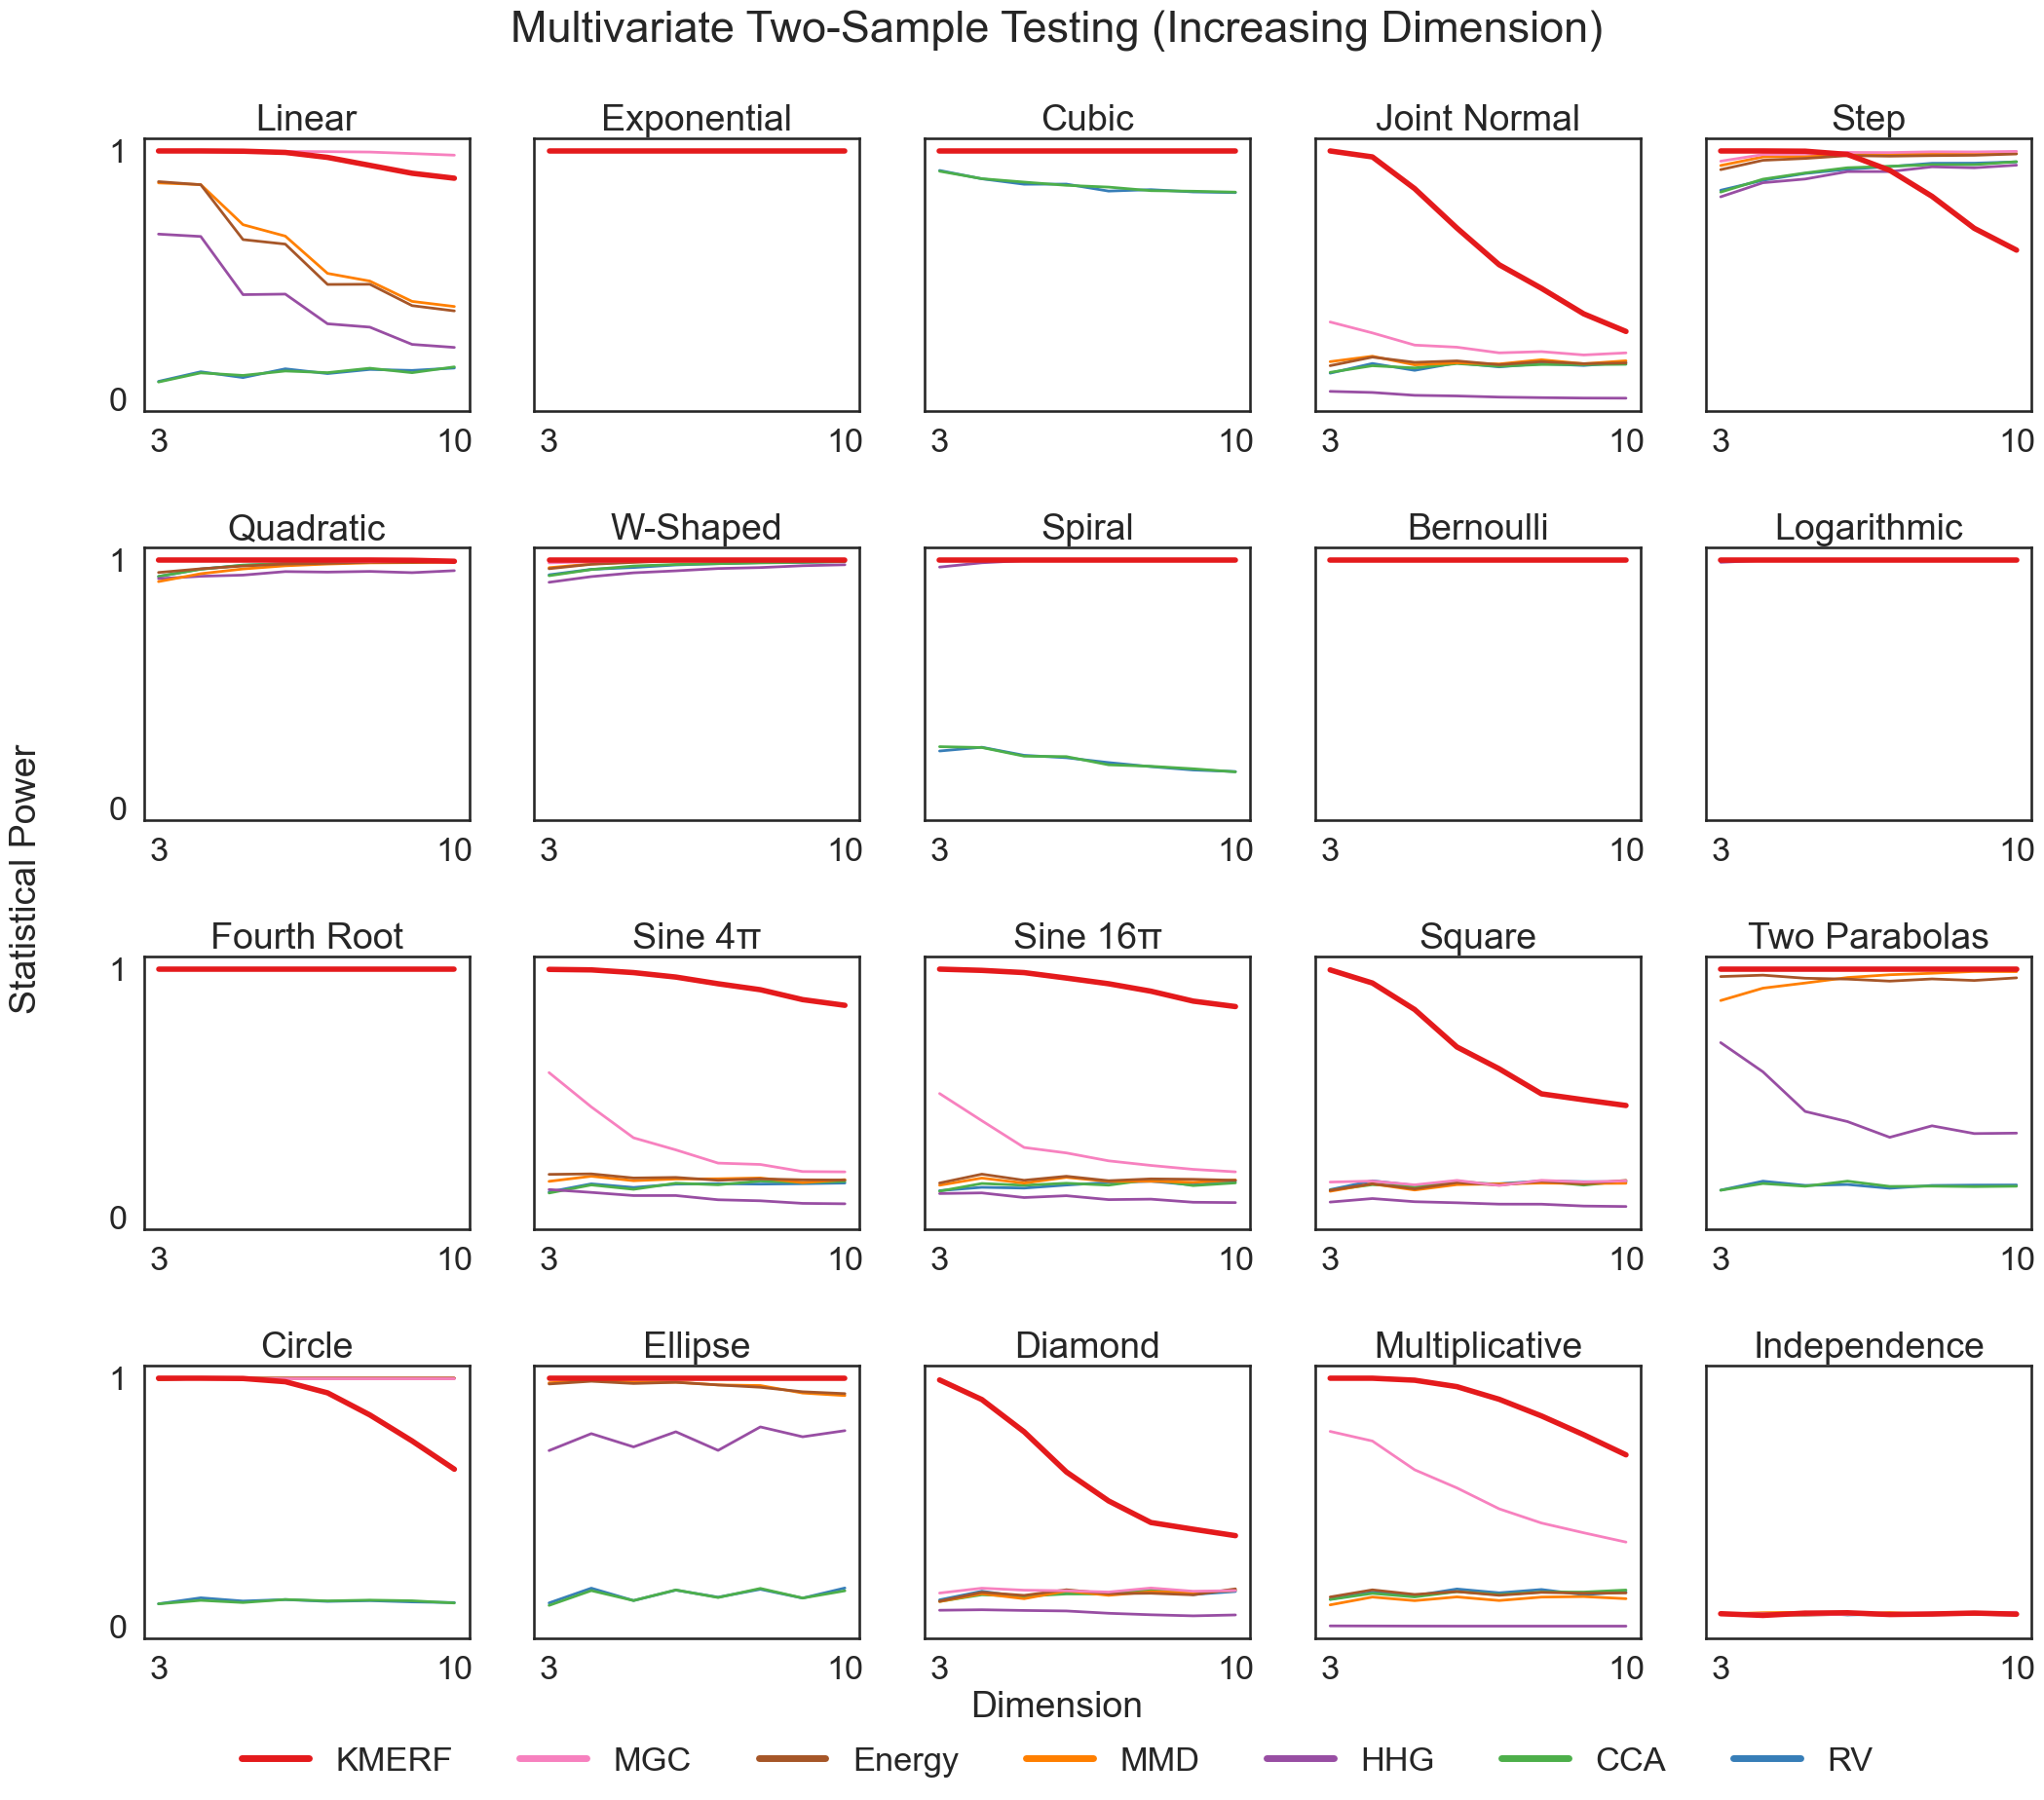

In [15]:
plot_power()